In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

def extract_sparse_features(image):
    
    # Resize image
    resized_image = cv2.resize(image, (64, 64))
    
    # Compute histogram of pixel intensities
    hist = cv2.calcHist([resized_image], [0], None, [16], [0, 256]).flatten()
    
    return hist

def load_images_with_features(directory):

    features = []
    labels = []
    
    # Get class labels from folder names
    breeds = [breed for breed in os.listdir(directory) if os.path.isdir(os.path.join(directory, breed))]
    
    for breed in breeds:
        path = os.path.join(directory, breed)
        
        # Find image files
        image_files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        for image_file in image_files:
            image_path = os.path.join(path, image_file)
            
            # Read image
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Resize to 224x224 if needed
            img = cv2.resize(img, (224, 224))
            
            # Extract sparse features
            sparse_features = extract_sparse_features(img)
            
            features.append(sparse_features)
            labels.append(breed)
    
    return np.array(features), np.array(labels)

def train_random_forest(train_dir, test_dir=None):

    # Load training data
    X_train, y_train = load_images_with_features(train_dir)
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    
    # Train random forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=123)
    rf_model.fit(X_train, y_train_encoded)
    
    # Get feature importances
    feature_importances = rf_model.feature_importances_
    
    # Test data processing
    if test_dir:
        X_test, y_test = load_images_with_features(test_dir)
        y_test_encoded = label_encoder.transform(y_test)
        
        # Predict and evaluate
        y_pred = rf_model.predict(X_test)
        
        # Classification report generation
        report = classification_report(y_test_encoded, y_pred, 
                                    target_names=label_encoder.classes_,
                                    output_dict=True)

        # Convert the classification report dictionary to a df
        report_df = pd.DataFrame(report).transpose()

        # Save the DataFrame to an Excel file
        report_df.to_excel("classification_report.xlsx", index=True)
        
        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(feature_importances)), feature_importances)
        plt.title('Feature Importances')
        plt.xlabel('Feature Index')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.show()
        
        return rf_model, feature_importances, label_encoder
    
    return rf_model, feature_importances, label_encoder


Classification Report saved to 'classification_report.xlsx'


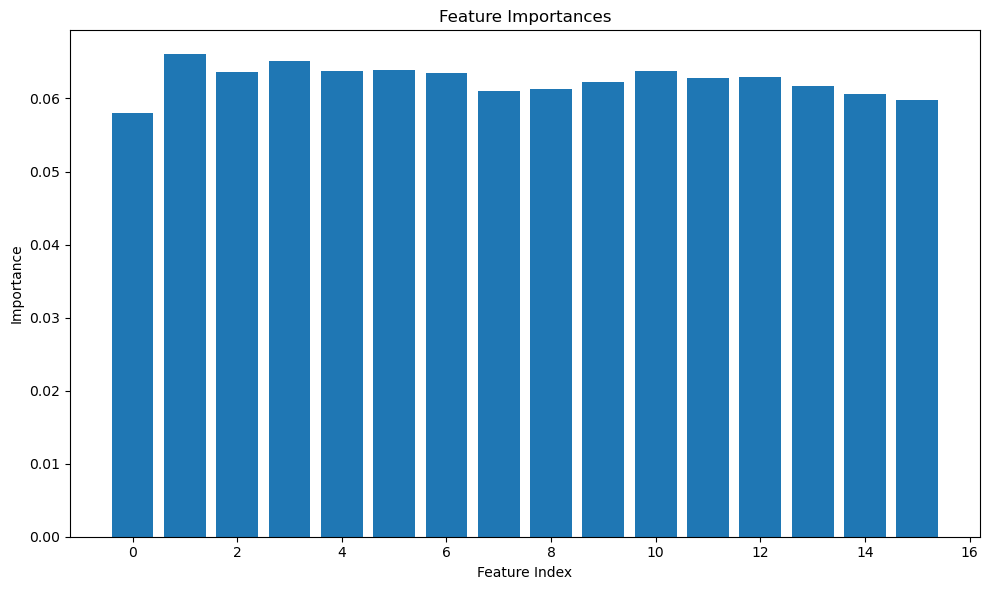

Predicted class for Luna: Dalmation
Predicted class for Phoebe: Doberman


In [2]:

def predict_on_new_image(image_path, model, label_encoder):

    # Read and preprocess image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    
    # Extract sparse features
    sparse_features = extract_sparse_features(img).reshape(1, -1)
    
    # Predict
    prediction_encoded = model.predict(sparse_features)[0]
    predicted_class = label_encoder.inverse_transform([prediction_encoded])[0]
    
    return predicted_class

# Example usage with Kadie's Dogs
if __name__ == "__main__":
    train_dir = "../data/70-dog-breedsimage-data-set-updated/train"
    test_dir = "../data/70-dog-breedsimage-data-set-updated/test"
    
    # Train model
    model, importances, label_encoder = train_random_forest(train_dir, test_dir)
    
    # Predict on Kadie's Dogs
    luna_image_path = "../data/kadie-dogs/luna.png"
    luna_predicted_class = predict_on_new_image(luna_image_path, model, label_encoder)
    print(f"Predicted class for Luna: {luna_predicted_class}")
    phoebe_image_path = "../data/kadie-dogs/phoebe.jpg"
    phoebe_predicted_class = predict_on_new_image(phoebe_image_path, model, label_encoder)
    print(f"Predicted class for Phoebe: {phoebe_predicted_class}")